## Fuentes 

**Notebook original en [EQUILAGO](https://github.com/equialgo/fairness-in-ml), basado en [UCBerkeley](https://fairmlclass.github.io/)**

**Este notebook es una traducción con algunas adiciones del notebook original de *Stijn Tonk* https://github.com/equialgo/fairness-in-ml**

**Código originial en [EQUILAGO](https://github.com/equialgo/fairness-in-ml)**

**Explicación el [GoDataDriven](https://godatadriven.com/blog/towards-fairness-in-ml-with-adversarial-networks/)**

**Se ha realizado traducción de explicaciones, adición de algunas explicaciones, comentarios en el código y alguna pequeña modificación en el mismo**

**Añadido anexo explicativo de GAN**

----------------------------------------------------------

# Debiasing para modelos con modelos adversariales

***Adrián Arnaiz-Rodríguez***

Desde las calificaciones crediticias hasta la asignación de viviendas, los modelos de aprendizaje automático se utilizan cada vez más para automatizar los procesos de toma de decisiones 'cotidianos'. Con el creciente impacto en la sociedad, se expresan cada vez más preocupaciones sobre la pérdida de transparencia, responsabilidad y equidad de los algoritmos que toman las decisiones. Nosotros, como científicos de datos, necesitamos mejorar nuestro juego y buscar formas de mitigar la discriminación emergente en nuestros modelos. Necesitamos asegurarnos de que nuestras predicciones no perjudiquen de manera desproporcionada a las personas con ciertas características sensibles (por ejemplo, género, etnia).

In [1]:
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model

import os
import imageio
create_gif = True

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")

Using TensorFlow backend.


sklearn: 0.22.1
pandas: 1.0.4
kerads: 2.3.1


## Predicciones de salario 
Predeciremos el salario de una persona, si es menor o mayor a 50k. Lo haremos según el datasert [adult UCI](https://archive.ics.uci.edu/ml/datasets/Adult). Esto puede ser dependiente de productos sensibles como la raza o el sexo. Por ello, les eliminamos de nuestro conjunto de características. Sin embargo, aunque no estén en nuestro conjunto de características, dada la alta correlación con otros atributos podemos tener el mismo sesgo de manera indirecta.

Nuestro dataset estará formado por 3 conjuntos: características, clases y atributos sensibles. Las características no contienen los atributos sensibles. La clase es $y \in \{income>50K, income\leq 50K\} $. Los atributos sensibles son: 

* $z_{race} \in \{black, white\}$

* $z_{sex}\in\{male, female\}$. 


**Carga de datos**

In [2]:
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

In [3]:
X, y, Z = load_ICU_data('data/adult_data.csv')
X.head(3)

features X: 30940 samples, 94 attributes
targets y: 30940 samples
sensitives Z: 30940 samples, 2 attributes


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Unknown,country_Vietnam,country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [4]:
Z.head(3)

,race,sex
0,1,1
1,1,1
2,1,1


Dividimos los conjuntos de train y test. Lo hacemos 60-40 porque tenemos muchos ejemplos. Estratificamos por clase.

In [5]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.6, 
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

**Creación del predictor**

Utilizamos 3 capas de neuronas con la función ReLU y dropout. 

La salida será una neurona sigmoide que predecirá la probabilidad de una persona de ganar más de 50k.

In [6]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# initialise NeuralNet Classifier
clf = nn_classifier(n_features=X_train.shape[1])

# train on train set
history = clf.fit(X_train.values, y_train.values, epochs=20, verbose=0)

**Predecimos resultados**

Chqueamos el rendimiento del modelo mediante AUC (hay un poco de desbalanceamiento de clases).

In [7]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.1f}%")

ROC AUC: 0.90
Accuracy: 85.0%


------------------------------------

## Igualdad en el modelo

### Cualitativamente

Vamos a ver cómo se distribuye la predicción del salario según los valores de los atributos sensibles del modelo (incluso no habiéndolos visto el modelo)

In [8]:
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'race': ['black','white'],
            'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns): #recorremos los 2 atributos sensibles
        for attr_val in [0, 1]:
            ax = sns.distplot(y[Z[attr] == attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
        
    #Hacemos verbose de distintos elementos: iteracion, métricas de rendimiento y regla p-rule de equidad    
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]*100:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
        
    fig.tight_layout()
    
    #Guardamos la figura
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    return fig

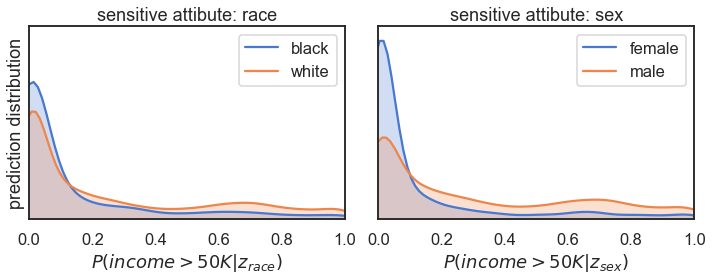

In [9]:
fig = plot_distributions(y_pred, Z_test)

Vemos que el modelo está claramente sesgado por sexo, no tanto por raza. El modelo está claramente sesgado a favor de los hombres y un poco a favor de los blancos.

### Cuantitativamente - p%-rule

Veremos cun una medida numérica el sesgo del modelo. Utilizaremos **p%-rule** una medida basada en los **odds**. Para ello calculamos los odds de la probabilidad de tener un sueldo mayor que 50k de los hombres sobre las mujeres, calculamos los odds de la probabilidad de tener un sueldo mayor que 50k de las mujeres sobre las hombres y nos quedamos con el menor de esos dos odds. Se realiza lo mismo para la raza.

$$\min\left( \frac{P(\hat{y}=1|z=1)}{P(\hat{y}=1|z=0)}, \frac{P(\hat{y}=1|z=0)}{P(\hat{y}=1|z=1)} \right)\geq\frac{p}{100}$$

La regla establece que la razón entre la probabilidad (odds) de un resultado positivo dado que el atributo sensible es verdadero y la misma probabilidad dado que el atributo sensible es falso no es menor que 1. Entonces, cuando un clasificador es completamente justo, los odds serán 1, determinando la igualdad de probabilidades de tener un sueldo mayor que 50k para ambos sexos (o razas). Por el contrario, cuando es completamente injusto, satisface una regla% 0.

In [10]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) 

In [11]:
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race'])* 100:.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex'])* 100:.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute race; 45%-rule
	given attribute sex;  34%-rule


Esto significa que los hombres tienen un $1/0.33=3.03$ más de probabilidades de ser calsificados como salarioos de más de 50k que las mujeres.

---------------------------

## Des-sesgar el modelo

En este dataset de 1994, hemos visto que tenemos datos sesgados. Esto puede venir derivado de atributos como el nivel de educación o el código postal. Esos son atributos que tendrán una correlación con los atributos sensibles dadas las características sociodemográficas en ese dataset.

Hay dos opciones: des-sesgar el dataset o el modelo. Aquí mostraremos **cómo se des-sesga el modelo a través de redes adversariales.**

El aspecto clave de Debiasing es ser capaces de aprender la distribución subyacente de las variables latentes intrínsecas dentro del dataset de manera no supervisada. Otro ejemplo, en un problema de predicción de caras, quizás las caras del conjunto de train no sean representativas del conjunto general sobre el que testearemos o trabajará el modelo (muchas caras del mismo género la misma pose o etnia). Es decir, las caras que tenemos provienen de una distribución no representativa de la distribución real sobre la que queremos trabajar o testear. El objetivo es detectar de manera no supervisada, a través de detectar la distribución subyacente de los datos de entrenamiento (sin especificar que busque por género o etnia o etc.) y aprender esta distribución de los datos para usar esa distribución durante el entrenamiento para Debiasing el modelo. Con ello, podremos dessesgar clasificadores faciales sesgados. Lo mismo pasa con nuestro dataset, donde queremos desesgar un dataset sesgado por sexo y raza, tanto por las correlaciones entre datos como por las sobrerepresentaciones y desequilibrios en el dataset.

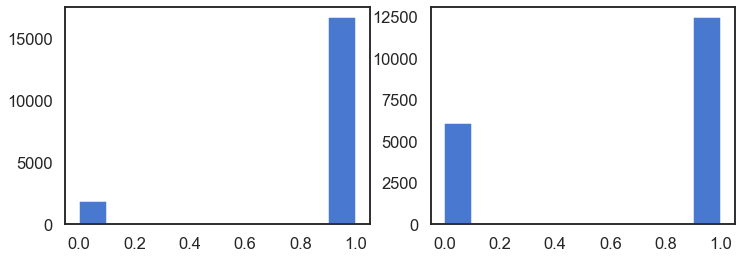

In [12]:
#Mostramos desequilibrio en el valor de los atributos
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(Z_test['race']);
plt.subplot(1,2,2)
plt.hist(Z_test['sex']);

## Entrenamiento adversarial para desesgar el modelo

Nuestro procedimiento para **entrenar a un clasificador de ingresos justos se inspira en las GAN** (para ver más de GAN ver anexo al final del notebook): aprovecha las redes adversarias para hacer cumplir la llamada **propiedad fundamental** (pivotal property) en el modelo predictivo. Esta propiedad estadística asegura que la distribución de resultados del modelo ya no depende de los llamados parámetros molestos. Estos parámetros no son de interés inmediato, pero deben tenerse en cuenta en un análisis estadístico. Al tomar los atributos sensibles como nuestros parámetros molestos, podemos hacer cumplir predicciones que son independientes de, en nuestro caso, la raza y el sexo. ¡Esto es exactamente lo que necesitamos para hacer predicciones justas!


El punto de partida para el entrenamiento adversarial de nuestro clasificador es la extensión de la arquitectura de red original con un componente adversario. La siguiente figura muestra cómo se ve esta arquitectura extendida:

![Arquitectura del clasificador desesgado adversarial](img/architecture.png "Arquitectura del clasificador desesgado adversarial")

A primera vista, este sistema de dos redes neuronales es muy similar al utilizado para entrenar GAN. Sin embargo, hay algunas diferencias clave. Primero, el **modelo generativo ha sido reemplazado por un modelo predictivo**. Entonces, en lugar de generar datos sintéticos, ahora genera predicciones reales $ \hat{y} $ basadas en la entrada $ X $. En segundo lugar, **la tarea del adversario ya no es distinguir los datos reales de los generados. En cambio, predice los valores de atributo sensibles $ \hat {z} \in \hat{Z} $ a partir de los $ \hat{y} $ predichos del clasificador**. Finalmente, los objetivos que ambas redes intentan optimizar se basan en las pérdidas de predicción del objetivo y los atributos sensibles, estos se denotan con $ Loss_ {y} (\theta_{clf}) $ y $ Loss_{Z} (\theta_{ clf}, \theta_{adv}) $ en la figura.

Consideremos la naturaleza del juego de suma cero en el que participan el clasificador y el adversario. **Para el clasificador el objetivo es doble: hacer las mejores predicciones posibles del nivel de ingresos al tiempo que se garantiza que la raza o el sexo no puedan derivarse de ellos**. Esto es capturado por la siguiente función objetivo:

$$\min_{\theta_{clf}}\left[Loss_{y}(\theta_{clf})-\lambda Loss_{Z}(\theta_{clf},\theta_{adv})\right]$$
* Vemos como la primera parte de la resta minimiza las pérdidas en clasificación.
* Vemos como la segunda parte de la resta maximiza la pérdida del discriminador (minimiza la opuesta a la pérdida).

**Entonces, aprende a minimizar sus propias pérdidas de predicción mientras maximiza la del adversario (debido a que $ \ lambda $ es positivo y minimizar una pérdida negada es lo mismo que maximizarlo). Tenga en cuenta que aumentar el tamaño de $ \ lambda $ dirige el clasificador hacia predicciones más justas mientras sacrifica la precisión de la predicción**. 

El objetivo durante el juego es más simple para el **adversario: predecir la raza y el sexo en función de las predicciones de nivel de ingresos del clasificador** (predecir sexo y raza a partir de la probabilidad de un individuo de ganar más de 50k). Esto se captura en la siguiente función objetivo:

$$ \min_{\theta_{adv}} \left[Loss_{Z} (\theta_{clf}, \theta_{adv}) \right]$$

Al adversario no le importa la precisión de predicción del clasificador. Solo le preocupa minimizar sus propias pérdidas de predicción.

**Ahora pasamos a la segunda fase de entrenamiento de redes adversariales: pasamos al procedimiento de entrenamiento de confrontación**. En resumen, podemos resumir este procedimiento en los siguientes 3 pasos:

1. Entrene previamente el clasificador en el conjunto de datos completo.
2. Entrene previamente al adversario en las predicciones del clasificador pre-entrenado.
3. Durante $T$ iteraciones se entrena simultáneamente las redes de adversarios (discriminador en GAN original) y clasificadores (generador en GAN original):
    1. Primero entrena al adversario para una sola época mientras mantienes el clasificador fijo
    2. Luego entrene al clasificador en un mini lote de muestra único mientras mantiene el adversario fijo.

El entrenamiento adversario real comienza solo después de los dos primeros pasos previos al entrenamiento. Es entonces cuando el procedimiento de entrenamiento imita el juego de suma cero durante el cual nuestro clasificador aprenderá (con suerte) cómo hacer predicciones que sean precisas y justas, para más información leer el anexo y el [paper original de Ian GoodFellow sobre GAN](https://arxiv.org/abs/1406.2661).

### Predicciones justas
Primero se crea un clasificador que satisfaga los requerimientos de las redes adversariales amoldadas a nuestro problema.

**Código orignial de Stijn Tonk.**

**Comentarios de Adrián Arnaiz.**

In [13]:
class FairClassifier(object):
    
    def __init__(self, n_features, n_sensitive, lambdas):
        
        #parámetro que pondera la importancia de la clasificación o la lucha contra el sesgo
        self.lambdas = lambdas
        
        #Entradas para el clasificador: número de características
        clf_inputs = Input(shape=(n_features,))
        #Entradas para el discriminador: probabilidad de ganar más de 50k
        adv_inputs = Input(shape=(1,))
        
        #Creamos arquitectura del clasificador
        clf_net = self._create_clf_net(clf_inputs)
        #Creamos arquitectura del adversario
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        #Establecemos las funciones para cambiar la entrenabilidad para ambas redes
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        
        #Compilamos el clasificador, estableciendo sus pesos como entrenables
        self._clf = self._compile_clf(clf_net)
        #Compilamos el adversario, estableciendo sus pesos como entremables y los del clf como congelados
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net, n_sensitive)
        #Compila el modelo del entrenamiento adverasarial, con pesos adversarios congelados y entrenabls para clf
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
                
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        '''
        Establecemos la red como entrenable o no. Se establece para que los pesos se mantengan firmes o se actualicen. 
        '''
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        '''
        Creamos la red de clasificación (asimilada a la parte generativa de la arquitectura GAN).
        Predice la probabilidad de un salario >50k
        
        Params
            Input: Capa de entrada de la red
        Return
            Red clasificadora con la arquitectura deseada
        '''
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
        return Model(inputs=[inputs], outputs=[outputs])
        
    def _create_adv_net(self, inputs, n_sensitive):
        '''
        Creamos la red discriminadora: predice la raza y el sexo a partir de la predicción del clasificador.
        Params
            Input: Capa de entrada de la red
        Return
            Red adversarial con la arquitectura deseada
        '''
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        outputs = [Dense(1, activation='sigmoid')(dense3) for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    def _compile_clf(self, clf_net):
        '''
        Compilamos la red clasificadora estableciendo los parámetros como entrenables.
            - Función de pérdida: Entropía cruzada.
        Params
            Modelo construido
        Return
            Modelo clasificacion compilado - primera fase
        '''
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        

    def _compile_adv(self, inputs, clf_net, adv_net, n_sensitive):
        '''
        Compilamos la red adversarial estableciendo los parámetros como entrenables.
        Importante: ESTABLECER LA RED GENERATIVA (CLASIFICADOR) COMO NO ENTRENABLE. 
        Esto se debe a que hemos encontrado el óptimo para el clasificador sin tener en cuenta los parámetros sensibles, 
        y ahora intentaremos averiguar los parámetros sensibles según esa predicción.
            - Función de pérdida: Entropía cruzada por el número de atributos sensibles.
        Params
            inputs: Entrada del modelo de clasificacion
            clf_net: modelo de clasificacion
            adv_net: modelo adversario
            n_sensitive: numero de variables de sesgo
        Return
            Red adversarial compilada con pesos congelados o entrenables - primera fase
        '''
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)) )
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_sensitive, optimizer='adam')
        return adv
    
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        '''
        Compilamos la red adversarial para el ENTRENAMIENTO ADVERSARIAL, con el objetivo de que el clasificador se DESSESGUE 
        y no se puedan predecir los parámetros sensibles. Por ello SE CONGELAN LOS PARÁMETROS DEL DISCRIMINADOR que con el
        anterior entrenamiento está optimizado para averiguar esos parámetros, y sólo actualizamos los pesos del clasificador.
        
            - Función de pérdida: Entropía cruzada por el número de pesos.
        Params
            inputs: Entrada del modelo de clasificacion
            clf_net: modelo de clasificacion
            adv_net: modelo adversario
        Return
            Red adversarial de la segunda fase compilada, para entrenamiento adversarial
        '''
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+adv_net(clf_net(inputs)))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compute_class_weights(self, data_set):
        '''
        Método que computa las instancias de cada clase para balancear. Lo hace dando peso a cada valor del atributo.
        Se busca que cada clase tenga un peso de 0.5 (si el valor es binario, sino 1/n_valores)
            N_mujer * Peso_mujer = N_hombre * Peso_hombre
            N_black * Peso_black = N_white * Peso_white
        Es decir:
            (N_mujer*Peso_mujer)/N_Total = (N_hombre*Peso_hombre)/N_Total = 0.5
            
        Devuelve los pesos para cada valor del atributo con el objetivo de aplicarlo a cada instancia y balancear el dataset.
        Este método es para los atributos.
        
        Params
            array de datos con diferentes valores
        Return
            peso para cada valor del atributo que aplicado a cada instancia balancea el dataset
        '''
        class_values = [0, 1]
        class_weights = []
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
        return class_weights
    
    def _compute_target_class_weights(self, y):
        '''
        Método que computa las instancias de cada clase para balancear. Lo hace dando peso a cada valor del atributo.
        Se busca que cada clase tenga un peso de 0.5 (si el valor es binario, sino 1/n_valores)
            N_biger50 * Peso_biger50 = N_less50 * Peso_less50.
        Es decir:
            (N_biger50*Peso_biger50)/N_Total = (N_less50*Peso_less50)/N_Total = 0.5
            
        Devuelve los pesos para cada clase con el objetivo de aplicarlo a cada instancia y balancear el dataset.
        Este método es para la clase objetivo.
        
        Params
            array de datos con diferentes valores
        Return
            peso para cada valor de la clase aplicado a cada instancia balancea el dataset
        '''
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        return class_weights
        
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        '''
        Método que realiza la primera parte del entrenamiento, la parte no adversarial, el pre-entrenamiento.
            1. Entrenamos clasificador.
            2. Entrenamos discriminador, en nuestro caso detector de atributos de sesgo (pesos de clf fijos).
        
        Params
            x: Características
            y: Etiquetas
            z: Valores sensibles o de sesgo
            epochs: Épocas de entrenamiento del clasificador y del adversario (por separado)
            verbose: Salida textual
        '''
        #1. Entrenamos la red del clasificador - 1a fase
        if verbose: print('Classifier Training')
        self._trainable_clf_net(True)
        self._clf.fit(x.values, y.values, epochs=epochs, verbose=verbose)
        
        #2. Entrenamos la red del discriminador - 1a fase
        if verbose: print('Discriminator Training')
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        #Establecemos peso de cada clase para simular el balanceo
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x.values, 
                      np.hsplit(z.values, z.shape[1]), 
                      class_weight=class_weight_adv, 
                      epochs=epochs, 
                      verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128, save_figs=False):
        '''
        Método que realiza el entrenamiento adversarial, mediante el cual el clasificador ya entrenado
        modifica sus pesos para que no se pueda predecir los atributos sensibles a partir de su predicción.
        Params
            x: Características
            y: Etiquetas
            z: Valores sensibles o de sesgo
            validation_data: datos de validacion
            T_iter: iteraciones del modelo
            batch_size: tamaño del lote de entrenamiento de la red
        '''
        n_sensitive = z.shape[1]
        if validation_data is not None:
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        for idx in range(T_iter):
            if validation_data is not None:
                y_pred = pd.Series(self._clf.predict(x_val).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                for sensitive_attr in z_val.columns:
                    self._fairness_metrics.loc[idx, sensitive_attr] = p_rule(y_pred,
                                                                             z_val[sensitive_attr])
                display.clear_output(wait=True)
                plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx],
                                   self._fairness_metrics.loc[idx], 
                                   fname=f'output/{idx+1:08d}.png' if save_figs else None)
                plt.show(plt.gcf())
            
            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=0)
            
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.train_on_batch(x.values[indices], 
                                           [y.values[indices]]+np.hsplit(z.values[indices], n_sensitive),
                                           class_weight=class_weight_clf_w_adv)

**Inicializamos y preentrenamos**

Los valores de $\lambda$ son los valores $\lambda_{raza}=30$ y $\lambda_{sexo}=30$. Son valores establecidos comprobados que aseguran un buen rendimiento y balanceo entre el rendimiento de clasificación y el p%-rule del sesgo.

In [14]:
clf = FairClassifier(n_features=X_train.shape[1], n_sensitive=Z_train.shape[1],
                     lambdas=[50., 30.])

# pre-train both adverserial and classifier networks
clf.pretrain(X_train, y_train, Z_train, verbose=1, epochs=5)

Classifier Training
Epoch 1/5
12376/12376 [==============================] - 1s 49us/step - loss: 0.4375
Epoch 2/5
12376/12376 [==============================] - 0s 35us/step - loss: 0.3553
Epoch 3/5
12376/12376 [==============================] - 0s 36us/step - loss: 0.3380
Epoch 4/5
12376/12376 [==============================] - 0s 35us/step - loss: 0.3322
Epoch 5/5
12376/12376 [==============================] - 0s 36us/step - loss: 0.3246
Discriminator Training
Epoch 1/5
12376/12376 [==============================] - 1s 55us/step - loss: 1.3216 - model_3_loss: 0.6470
Epoch 2/5
12376/12376 [==============================] - 0s 37us/step - loss: 1.2972 - model_3_loss: 0.6361
Epoch 3/5
12376/12376 [==============================] - 0s 36us/step - loss: 1.3003 - model_3_loss: 0.6349
Epoch 4/5
12376/12376 [==============================] - 0s 37us/step - loss: 1.2991 - model_3_loss: 0.6352
Epoch 5/5
12376/12376 [==============================] - 0s 37us/step - loss: 1.2969 - model_3_loss:

Ahora que ya hemos entrenado los dos modelos por separado podemos hacer el entrenamiento adversarial con el objetivo de aumentar el p%-rule de ambos atributos críticos a la vez que se mantiene el rendimiento en la predicción.

In [15]:
if create_gif:
    files = [f"output\\{file}" for file in os.listdir('output') if file.endswith('.png')]
    for f in files:
        os.remove(f)

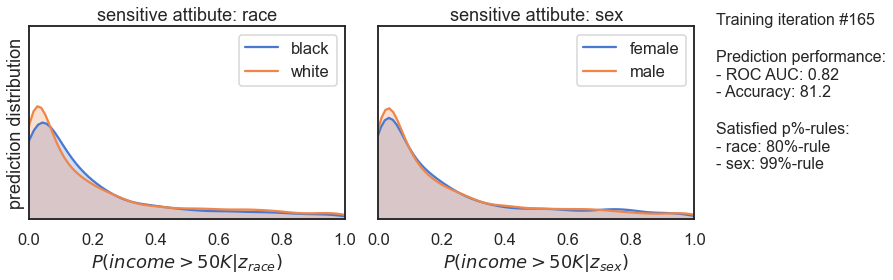

In [16]:
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=165, save_figs=create_gif)

In [17]:
if create_gif:
    files = [f"output\\{file}" for file in os.listdir('output')]
    images = [imageio.imread(file) for file in files]
    imageio.mimwrite('debiasing.gif', images, fps=15)


## Conclusión

**Vemos en los p%-rule como los odds de probabilidades de la etiqueta salario han conseguido des-sesgarse, llegando a muy buenos valores, viendo como se han des-sesgado el modelo casi al completo.**

**Vemos también como evidentemente la precisión ha sido penalizada, pero sólo un 7% en el accuarcy**

La ventaja de este modelo, aunque tenga menos precisión total que el primero, es que hemos conseguido desesgarle de manera samisupervisada y habiendo mantenido una alta precisión.

|              	| **Clasificador** <br>**original** 	| **Clasificador**<br>**des-sesgado** 	|
|--------------	|---------------------------	|-----------------------------	|
| AUC          	| 0.9                       	| 0.82                        	|
| Accuracy     	| 0.85                      	| 0.81                        	|
| p%-rule sexo 	| 0.34                      	| **0.80**                        	|
| p%-rule raza 	| 0.45                      	| **0.99**                        	|

-----------------------------

## Anexo - Redes Generativas Adversarias

Para el análisis del artículo ha sido utilizado tanto el artículo original [4], como la charla dada por Goodfellow en NIPS 2016 [3], como las diapositivas originales de esa presentación [2] . 
El artículo presentó novedades en cuanto al planteamiento de modelos generativos. El objetivo de los modelos generativos es tomar ejemplos de train de una distribución, enseñar al modelo esa distribución (estimar la función de distribución de probabilidad) y que el modelo genere datos de esa distribución. Es decir, aprender $P_{model}(x)$ similar a $P_{data}(x)$. El ejemplo más común es con imágenes de train que provienen de una distribución de probabilidad $P_{data}(x)$ y queremos generar nuevos ejemplos dibujados con la distribución de probabilidad del modelo $P_{model}(x)$. Normalmente los ejemplos de *train* son de una gran dimensionalidad, como audios o imágenes. 

La **novedad utilizada por estas redes es el término adversarial o antagónico,** con el que el modelo generativo se modela mediante un juego al estilo minimax (como el típico algoritmo Alpha-Beta) donde “un falsificador y un policía mejoran sus habilidades de forma simultánea dando lugar a un muy buen falsificador”. Es decir, plantea dos agentes, dos redes neuronales, jugando con objetivos totalmente opuestos. Se llama entrenamiento adversarial porque hace referencia a que la peor entrada (*worst case input*) para una de las redes es generada por la otra red. 
En términos exactos GAN tiene 2 agentes jugando un juego. Uno es el generador $G$, que genera datos según una función de probabilidad a partir de datos aleatorios. Otro es el discriminador, $D$, que examina los datos y determina si es real o mentira (si proviene de la distribución de los datos reales o no). El objetivo es que los dos mejoren cada vez, dado lugar a que el generativo cree datos tan realistas como sea posible. 


![Entrenamiento adversarial](img/GAN-Goodfellow.PNG "Entrenamiento adversarial GAN")
* Diapositiva de Ian GoodFellow [2-3]

La novedad es el propio algoritmo más que la experimentación en sí, por lo que primero comentaremos su formulación y entrenamiento. Se puede formalizar el proceso utilizando el *mini-max game* donde la función de coste de $D$, $J(D)$ es la función de entropía cruzada normal asociada con el problema de clasificación binaria de distinguir entre datos reales y falsos. Como tenemos 2 *batches* de datos de entrenamiento (reales y falsos), debemos estipular la función con 2 partes donde se minimice la posibilidad de tomar como real datos falsos y la posibilidad de tomar como false datos reales. La función de coste del discriminador, como hemos comentado, es la opuesta, por lo que será la siguiente: $J(G) = −J(D)$, lo que minimizará la probabilidad (en logaritmo) de que el discriminador acierte. Sin embargo, Ian Goodfellow comenta que, en vez de utilizar justo la función de coste contraria, se utilice otra función de coste donde se maximice la probabilidad de $D$ de fallar (parece lo mismo, pero media función se la carga, teniendo implicaciones matemáticas que mejoran el rendimiento). Esto es debido a que con la función original si el discriminador es muy bueno el gradiente de $G$ desciende exageradamente a 0. Es decir, la función de pérdida del generador puede tener mal comportamiento si el discriminador es muy bueno. Con las nuevas funciones se reduce ese efecto (no se elimina totalmente). 

Por ello las funciones son las siguientes:

$$\max_D \sum_{x \in P_{data}}{\log(D(x))} + \sum_{\hat{x}\in P_{model}}{1-\log(D(\hat{x}))}$$
$$\max_G \sum_{\hat{x}\in P_{model}}{\log(D(\hat{x}))}$$

El **proceso de entrenamiento** corresponde con el siguiente (relativo a imágenes porque es lo más habitual): primero entrenamos el Discriminador. El objetivo de $D$ es que $D(x)$ siendo 𝑥 una imagen real del dataset se acerque a 1. Esto significará que 𝑥 es un ejemplo real que proviene de nuestro conjunto de datos. 

Por otro lado, en la otra mitad del entrenamiento, tenemos un ejemplo de *random noise* 𝑍 de una prior distribución de variables latentes. 𝑍 es ruido aleatorio que permite al generador crear muchas imágenes realistas y no sólo una. Después, la aplicamos la función Generador $G$. Al igual que $D$, $G$ es una función diferencial controlada por un set de parámetros. En nuestro caso, ambas dos funciones están interpretadas como MLP. 

Después de aplicar la función $G$ al ruido aleatorio z, $G(z)$, tenemos un valor de X, una muestra del modelo que intenta representar una muestra de los datos reales. Es decir, este ejemplo X será razonablemente similar a la distribución de los datos, pero tendrá ligeras variaciones que $D$ podrá detectar. En este punto aplicamos el discriminador al ejemplo falso: $D(G(z))$. En este punto el discriminador $D$ intenta que $D(G(z))=0$. Simultáneamente $G$ compite intentando que $D(G(z))=1$. Aquí vemos el *minimax game* formulado con las anteriores fórmulas. Podemos utilizar teoría de juegos para analizar la situación y llegar a la conclusión de que tanto la policía ($D$) como los falsificadores ($G$) aumentan las capacidades de detectar y crear moneda falsa respectivamente, hasta llegar a que los falsificadores creen moneda exactamente igual a la real, no pudiendo distinguir la policía entre real y falso, dando probabilidades de $\frac{1}{2}$ a las instancias. 

También se **demuestra la convergencia** del método. Se demuestra que el punto de equilibrio del juego *minimax* es un punto de silla, *saddle point* o *minimax point*. Sin embargo, no siempre converge. Cuando tenemos una única función de coste, tenemos un problema de optimización donde no deberíamos tener problema con la convergencia. 

Cuando jugamos a *minmax*, donde se intentan minimizar dos funciones opuestas simultáneamente, podemos no obtener nunca el equilibrio óptimo. Una de las peores formas de no convergencia de las GAN es lo que se llama *Mode Collapse* *(Helvetica Scenario*). Cuando hacemos minimax podemos establecer el min o el max en el *inner-oloop* o *outer-loop*. 

**Algunas conclusiones a las GAN**

1. “No necesariamente entrenar mucho, sino entrenar en los casos más difíciles relacionados con el aspecto que quieres mejorar y recibir feedback de un experto que te asesore en la dirección correcta es la mejor manera de aprender” (Goodfellow, Introduction to GANs, NIPS 2016 | Ian Goodfellow, OpenAI, 24) [3]

2. La conclusión de **aplicación** es que puede ser utilizado para economía: encontrar óptimos en juegos con diferentes payoffs, como encontrar el precio justo de un producto en el mercado.  

3. GANs son modelos generativos que usan aprendizaje supervisado para estimar una función de distribución de probabilidad (density ratio). 

4. GANs permiten al modelo a aprender que **hay muchas respuestas correctas**. Se produce por lo siguiente: cuando nosotros tenemos una entrada en estas redes generativas, podemos tener varias respuestas de salida correctas (que D considere verdaderas) y no solo una. Otros métodos basados en MSE, determinan solo una respuesta correcta para cada entrada. Esto implica una pega, al final el modelo acabe aprendiendo cosas como generar imágenes basándose en la media de las reales, dando lugar por ejemplo a las imágenes borrosas. Con GANs se admiten varias salidas correctas, lo que mitiga este problema: en vez de hacer la media elegirá una de las diferentes correctas (i.e. en fotos, en vez de elegir una imagen de un ojo borroso elegirá un ojo mejor definido de todos los del conjunto de datos). Las GANs en realidad no usan directamente un par de entradas y salidas para decirle al modelo lo que debe hacer, sino que el generador aprende cómo se pueden emparejar las entradas y salidas y luego el discriminador le dice al modelo si ha hecho un buen trabajo o no. El discriminador, que idealmente aprende que todos los datos del conjunto real son opciones posibles, luego, cuando el generador produce un dato del conjunto de entrada (sea el punto que sea) el discriminador dice que eso ha sido algo correcto. Existen muchas cosas buenas que el modelo puede hacer y es de esperar que el discriminador los respalde a todos, por lo que ahora tenemos este mecanismo para decir que son posibles muchos resultados diferentes en lugar de dirigir siempre el modelo hacia una respuesta predefinida (como MSE).

5. Se puede utilizar como modelo final o como modelo de ayuda a otros modelos de ML (i.e. el caso de este notebook, donde se ha utilizado para hacer debiasing).

**Bibliografía del anexo sobre GANs**
1. Amini, A. (Enero de 2019). MIT 6.S191 (2019): Deep Generative Modeling. Obtenido de https://www.youtube.com/watch?v=yFBFl1cLYx8 
 
2. Goodfellow, I. (9 de Diciembre de 2016). Introduction to Generative Adversarial Networks. NIPS 2016 Workshop on Adversarial Training. Barcelona. Obtenido de http://www.iangoodfellow.com/slides/2016-12-9-gans.pdf 
 
3. Goodfellow, I. (2017 de Agosto de 24). Introduction to GANs, NIPS 2016 | Ian Goodfellow, OpenAI. Obtenido de https://www.youtube.com/watch?v=9JpdAg6uMXs 
 
4. Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., . . . Bengio, Y. (2014). Generative Adversarial Networks. En Z. Ghahramani, & M. Welling, Advances in Neural Information Processing Systems 27 (págs. 2672-2680). Curran Associates, Inc. Obtenido de http://papers.nips.cc/paper/5423generative-adversarial-nets.pdf

---------------------